In [1]:
cd ..

/work


In [2]:
%load_ext autoreload
%autoreload 2

import time 
from src.dbscan import *
from src.utils import *
from src.metrics import *
from src.clusterization_performance import *
from src.datasets import Dataset
from src.dbscanrn import *
from src.normalization import *

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(0)
# plt.style.use('dark_background')

# Datasets

### Dataset from lecture

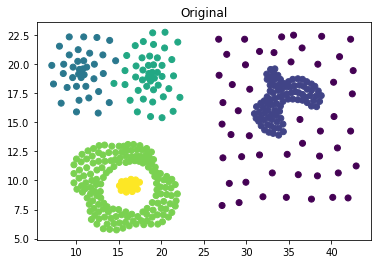

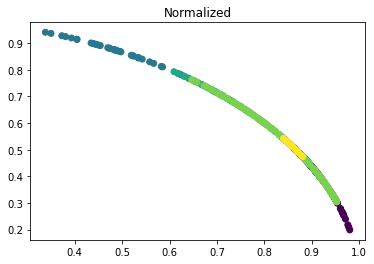

In [3]:
dataset = Dataset('./data/compound_dataset.txt')
X, y = dataset.X, dataset.y
display_points(X, y, 'Original', numerate=False)

normalization = Norm()
X = normalization.run(X)
display_points(X, y, 'Normalized', numerate=False)

# DBSCANRN (cosine dissimilarity)

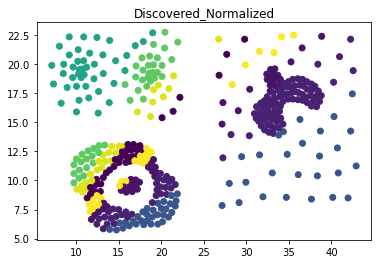

'./out/LOG_dbscanrn_compound_dataset_D2_R399_k25_cosine_dissimilarity.log'

In [4]:
timer_start = time.time()
params = {
    'k': 25,
    'similarity': cosine_dissimilarity
}

algorithm = DBSCANRN(**params)

name = get_name(
    algorithm_name=algorithm.name, 
    dataset_name=dataset.name, 
    n_dimentions=dataset.n_dimentions, 
    n_rows=dataset.n_rows,
    **params
)

algorithm.log_output = f'./out/LOG_{name}.log'
algorithm.fit_transform(X)
total_runtime = (time.time() - timer_start) * 1000

display_points(dataset.X, algorithm.y_pred, 'Discovered_Normalized', numerate=False)
score = evaluate(algorithm.y_pred, y, algorithm.X)
algorithm.log_output

# OUT

In [6]:
timer_start = time.time()
logs = algorithm.get_logs()
mask = logs['operation'] == 'similarity_calculation'
similarity_calculation = logs[mask].groupby('point_id').sum().reset_index().drop(columns=['time [ms]'])
similarity_calculation.rename(columns={'value': '# of distance/similarity calculations'}, inplace=True)

out = pd.DataFrame({
    'point_id': np.arange(dataset.n_rows),
    'x': algorithm.X[:, 0],
    'y': algorithm.X[:, 1],
    'point_type': algorithm.state, # 1 - core, 0 - border, -1 - noise
    'CId': algorithm.y_pred # clusters: cluster identifier or -1 in the case of noise points
})

out = out.merge(similarity_calculation, on='point_id')
out.to_csv(f'./out/OUT_{name}.csv', index=False)
saving_OUT_time = (time.time() - timer_start) * 1000
out.head()

,point_id,x,y,point_type,CId,# of distance/similarity calculations
0,0,0.770224,0.637774,1,74,398.0
1,1,0.802578,0.596547,1,2,398.0
2,2,0.831239,0.555916,1,78,398.0
3,3,0.798960,0.601384,1,2,398.0
4,4,0.831836,0.555021,1,78,398.0


# STAT

In [9]:
timer_stat = time.time()
stat = pd.DataFrame({
    'name of the input fil': dataset.name,
    '# of dimensions of a point': dataset.n_dimentions,
    '# of points in the input file': dataset.n_rows,
    'epsilon': params['epsilon'] if 'epsilon' in params else '',
    'minPts': params['minPts'] if 'minPts' in params else '',
    'k':  params['k'] if 'k' in params else '',
    'similarity': params['similarity'].__name__,
    'values of dimensions of a reference point': '',
    'reading the input file': dataset.runtime,
    # 'normalization of vectors': normalization.runtime,
    "Eps-neighborhood timer": logs['time [ms]'][logs['operation'] == 'Eps_time'].sum(),
    'Clustering timer': logs['time [ms]'].max(),
    'saving results to OUT': saving_OUT_time,
    'total runtime': total_runtime,
    '# of discovered clusters': sum(out['CId'] > -1),
    '# of discovered noise points': sum(out['point_type'] == -1),
    '# of discovered core points': sum(out['point_type'] == 1),
    '# of discovered border points': sum(out['point_type'] == 0),
    'avg # of calculations of distance/similarity': out['# of distance/similarity calculations'].mean(),
    '|TP|': score['TP'],
    '|TN|': score['TN'],
    '# of pairs of points': len(algorithm.y_pred),
    'RAND': score['rand_score'],
    'Purity': score['purity'],
    'Silhouette coefficient': score['silhouette_score_euclidean'],
    'Davies Bouldin': score['davies_bouldin_score']
}, index=['values']).T
stat_time = time.time() - timer_stat
print(stat_time)
stat.to_csv(f'./out/STAT_{name}.csv', index=False)
stat

0.010318756103515625


,values
name of the input fil,compound_dataset
# of dimensions of a point,2
# of points in the input file,399
epsilon,
minPts,
k,25
similarity,cosine_dissimilarity
values of dimensions of a reference point,
reading the input file,14.927626
Eps-neighborhood timer,0.0


# DEBUG

In [8]:
mask1 = logs['operation'] == '|knn_neighbors|'
mask2 = logs['operation'] == 'knn_neighbors_id'
mask3 = logs['operation'] == '|rnn_neighbors|'
mask4 = logs['operation'] == 'rnn_neighbors_id'

debug1 = (
    logs[mask1]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'value', 
    )
)
debug1.reset_index(col_level=1, inplace=True)
debug1.columns.name = None

debug2 = (
    logs[mask2]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'string', 
        aggfunc=lambda x: ' '.join(x)
))   
debug2.reset_index(col_level=1, inplace=True)
debug2.columns.name = None

debug3 = (
    logs[mask3]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'value', 
    )
)
debug3.reset_index(col_level=1, inplace=True)
debug3.columns.name = None

debug4 = (
    logs[mask4]
    .fillna('')
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'string', 
        aggfunc=lambda x: ' '.join(x)
))   
debug4.reset_index(col_level=1, inplace=True)
debug4.columns.name = None


debug = debug1.merge(debug2, on='point_id').merge(debug3, on='point_id').merge(debug4, on='point_id')
debug.to_csv(f'./out/DEBUG_{name}.csv', index=False)
debug

,point_id,|knn_neighbors|,knn_neighbors_id,|rnn_neighbors|,rnn_neighbors_id
0,0.0,25.0,215;243;231;272;273;265;232;268;235;234;244;22...,22.0,215;243;231;272;273;265;232;268;235;234;244;22...
1,1.0,25.0,321;223;275;322;266;280;3;279;315;318;316;319;...,25.0,321;223;275;322;266;280;3;279;315;318;316;319;...
2,2.0,25.0,325;4;329;330;334;282;47;281;326;278;324;333;3...,21.0,325;4;329;330;334;282;47;281;326;278;324;333;3...
3,3.0,25.0,280;266;279;275;223;316;1;321;319;222;246;322;...,25.0,280;266;279;275;223;316;1;321;319;222;246;322;...
4,4.0,25.0,2;325;330;329;334;282;47;281;326;333;395;278;3...,24.0,2;325;330;329;334;282;47;281;326;333;395;278;3...
...,...,...,...,...,...
394,394.0,25.0,285;284;286;46;398;48;332;335;387;8;6;331;395;...,22.0,285;284;286;46;398;48;332;335;387;8;6;331;395;...
395,395.0,25.0,333;331;6;332;47;48;398;46;282;286;334;284;285...,20.0,333;331;6;332;47;48;398;46;282;286;334;284;285...
396,396.0,25.0,336;283;337;393;8;397;387;51;388;335;386;52;50...,22.0,336;283;337;393;8;397;387;51;388;335;386;52;50...
397,397.0,25.0,51;393;388;337;386;52;396;336;283;50;7;49;8;39...,16.0,51;393;388;337;386;52;396;336;283;50;7;49;8;39...
